https://colab.research.google.com/github/Lucien-Piat/DEL_Single_Tree_Detection/blob/main/notebook.ipynb

In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
from IPython.display import clear_output
from src.data_pipeline import make_dataset

EPOCHS = 20
BATCH_SIZE = 32

In [2]:
train_dataset = make_dataset('../data/gold/train', batch_size=BATCH_SIZE)
valid_dataset = make_dataset('../data/gold/valid', batch_size=BATCH_SIZE)
test_dataset = make_dataset('../data/gold/test', batch_size=BATCH_SIZE)

---

In [3]:
import tensorflow as tf
from src.pix2pix import pix2pix

In [4]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [5]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [14]:
def unet_model(output_channels:int = 1):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
class MeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        print(y_true.shape, y_pred.shape)

        return super().update_state(
            tf.argmax(y_true, axis=-1), 
            tf.argmax(y_pred, axis=-1), 
        sample_weight)

model = unet_model()
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        'accuracy',
        # MeanIOU(num_classes=OUTPUT_CLASSES)
    ]
)

2024-04-23 12:21:10.128615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


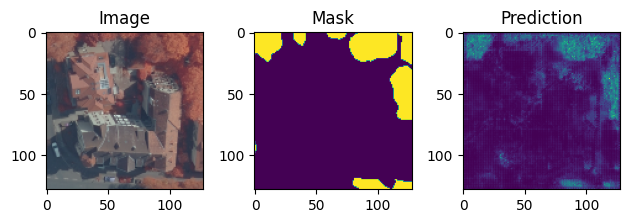

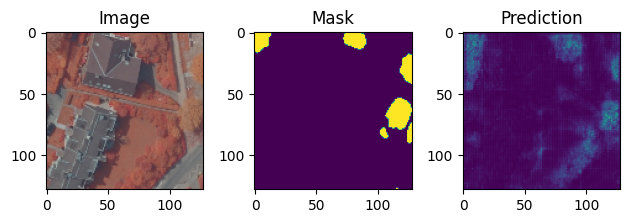

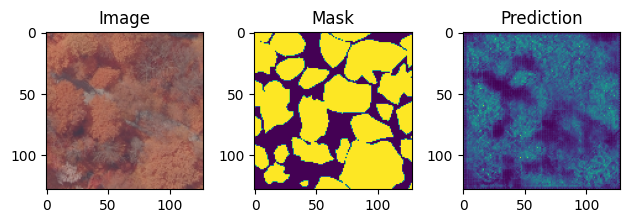

In [27]:
import matplotlib.pyplot as plt 

def show_predictions(n = 3):
    for image, mask in list(valid_dataset.take(n)):
        pred_mask_logits = model.predict(image, verbose=0)
        pred_mask = tf.sigmoid(pred_mask_logits)
        plt.subplot(1, 3, 1)
        plt.imshow(image[0])
        plt.title('Image')
        plt.subplot(1, 3, 2)
        plt.imshow(mask[0])
        plt.title('Mask')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[0, :, :, 0])
        plt.title('Prediction')
        plt.tight_layout()
        plt.show()  

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))
        show_predictions()

show_predictions()

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7196 - loss: 0.0078
Sample Prediction after epoch 1



2024-04-23 12:25:29.171058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


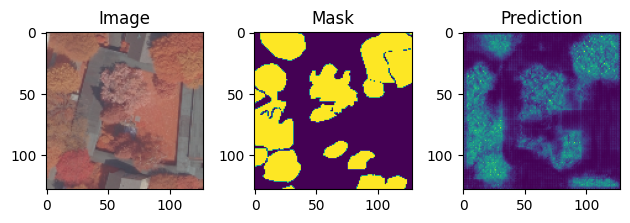

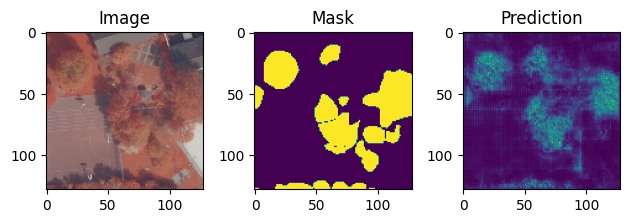

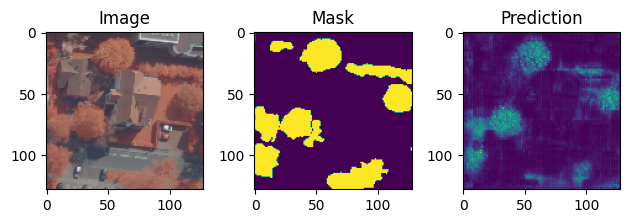

100/100 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.7196 - loss: 0.0078 - val_accuracy: 0.7120 - val_loss: 0.0081
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7210 - loss: 0.0077
Sample Prediction after epoch 2



2024-04-23 12:28:56.620195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


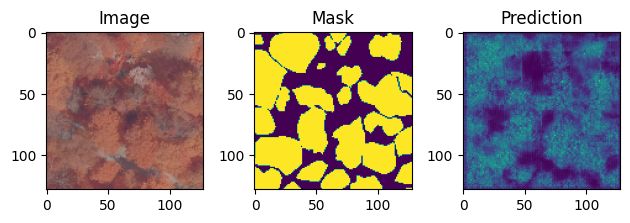

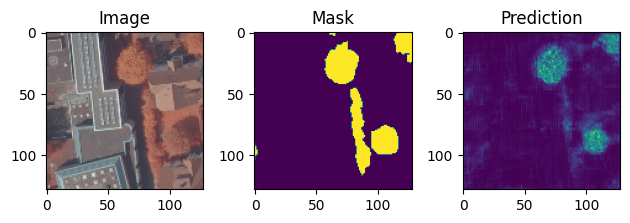

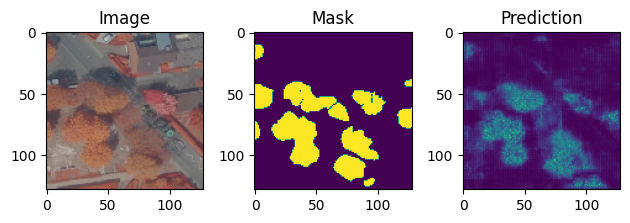

100/100 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.7210 - loss: 0.0077 - val_accuracy: 0.7145 - val_loss: 0.0080
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7201 - loss: 0.0077
Sample Prediction after epoch 3



2024-04-23 12:32:18.216894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


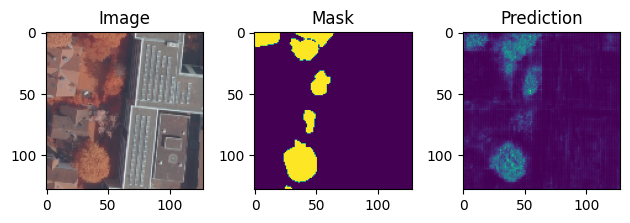

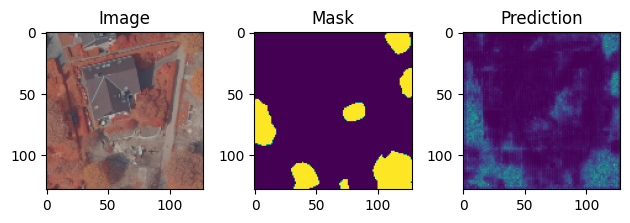

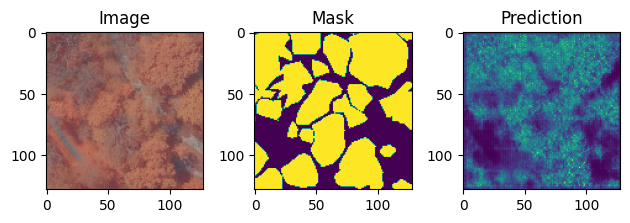

100/100 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.7201 - loss: 0.0077 - val_accuracy: 0.7103 - val_loss: 0.0081
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7224 - loss: 0.0077
Sample Prediction after epoch 4



2024-04-23 12:35:40.548129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


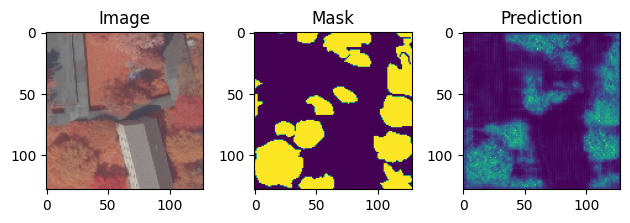

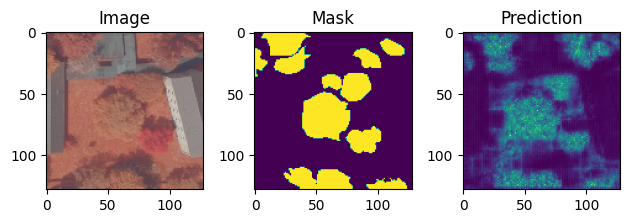

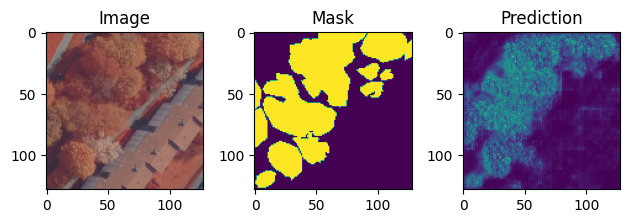

100/100 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7225 - loss: 0.0077 - val_accuracy: 0.7097 - val_loss: 0.0081
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7232 - loss: 0.0076
Sample Prediction after epoch 5



2024-04-23 12:39:13.703394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


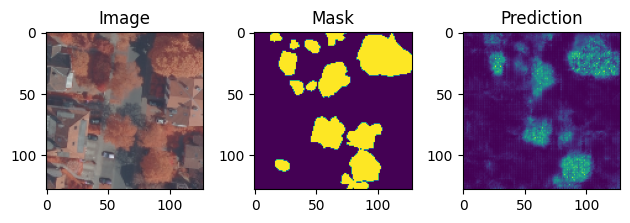

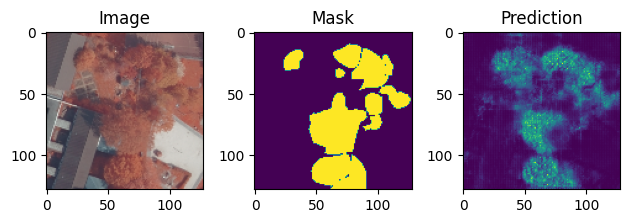

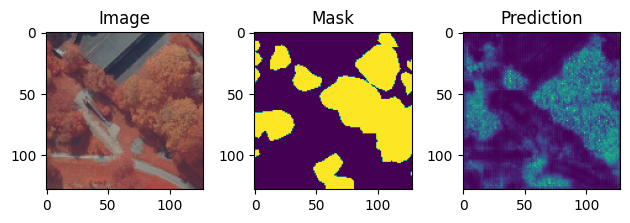

100/100 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.7232 - loss: 0.0076 - val_accuracy: 0.7122 - val_loss: 0.0080
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7204 - loss: 0.0077
Sample Prediction after epoch 6



2024-04-23 12:42:51.340467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


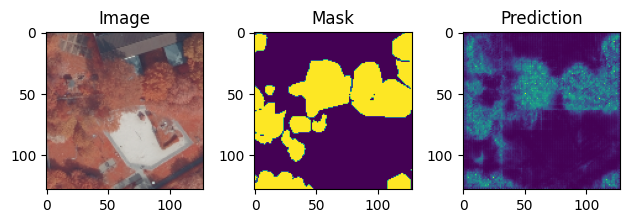

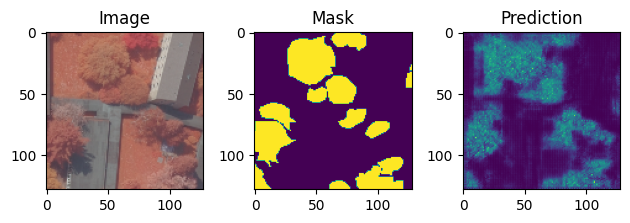

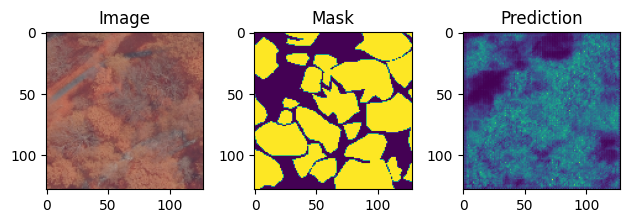

100/100 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.7204 - loss: 0.0077 - val_accuracy: 0.7141 - val_loss: 0.0080
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7219 - loss: 0.0076
Sample Prediction after epoch 7



2024-04-23 12:46:14.919077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


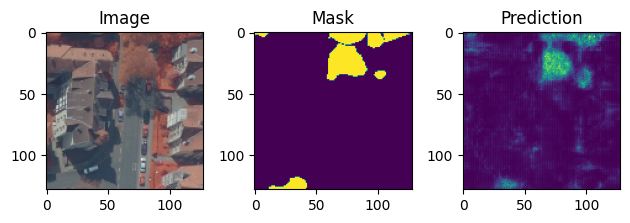

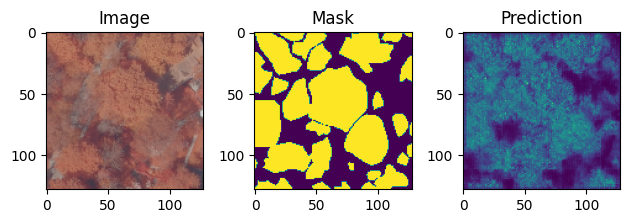

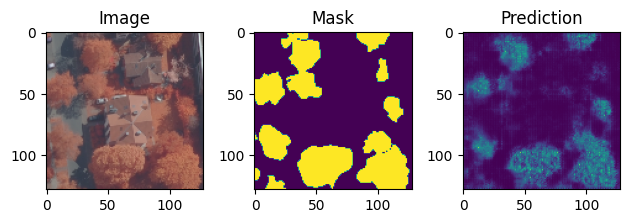

100/100 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7219 - loss: 0.0076 - val_accuracy: 0.7133 - val_loss: 0.0080
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7237 - loss: 0.0076
Sample Prediction after epoch 8



2024-04-23 12:50:06.769925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


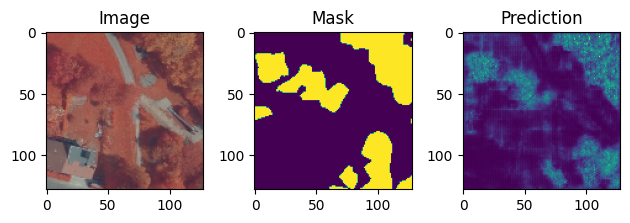

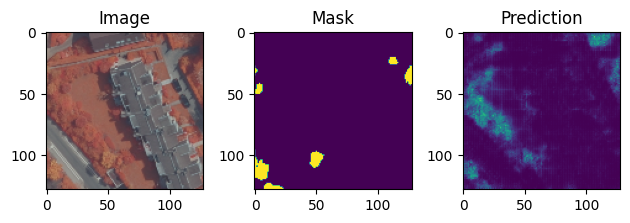

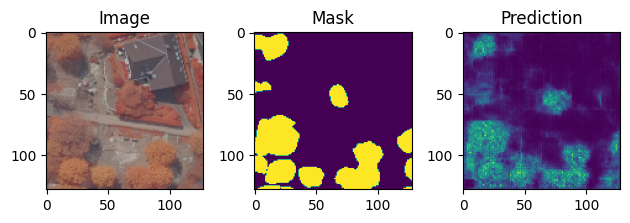

100/100 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.7237 - loss: 0.0076 - val_accuracy: 0.7122 - val_loss: 0.0080
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7239 - loss: 0.0076
Sample Prediction after epoch 9



2024-04-23 12:54:03.148395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


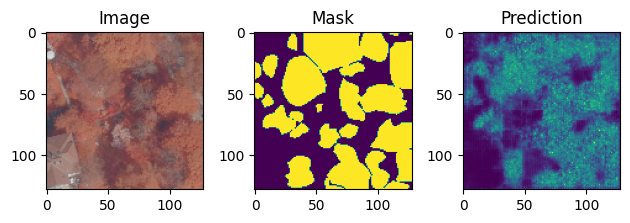

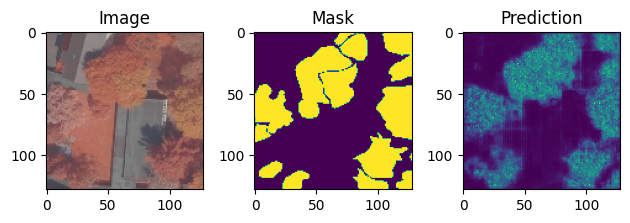

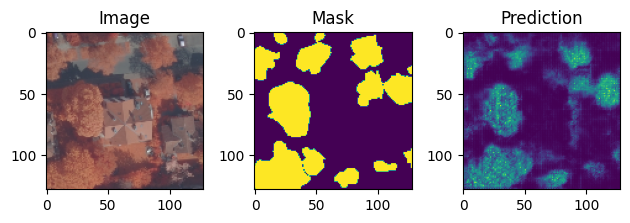

100/100 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.7239 - loss: 0.0076 - val_accuracy: 0.7130 - val_loss: 0.0079
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7278 - loss: 0.0074
Sample Prediction after epoch 10



2024-04-23 12:57:59.600737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


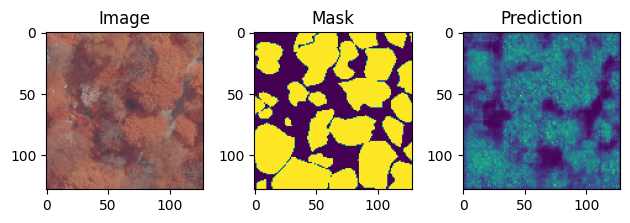

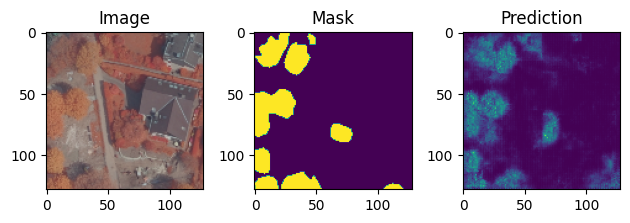

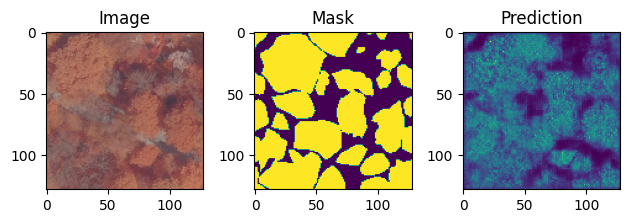

100/100 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.7278 - loss: 0.0074 - val_accuracy: 0.7123 - val_loss: 0.0080


In [29]:
train_steps = 100
valid_steps = 100

model_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=valid_dataset,
    callbacks=[DisplayCallback()]
)

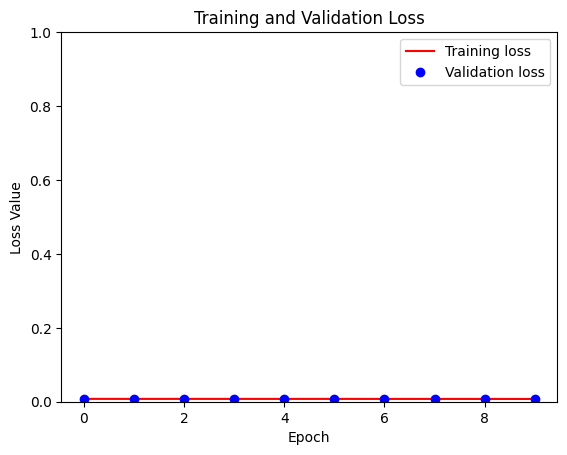

In [30]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2024-04-23 12:58:10.879878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


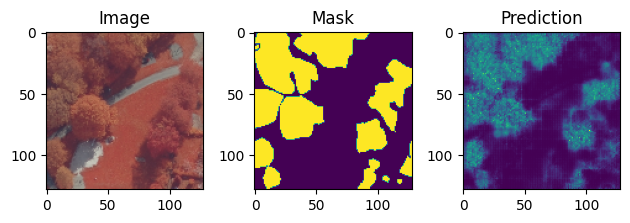

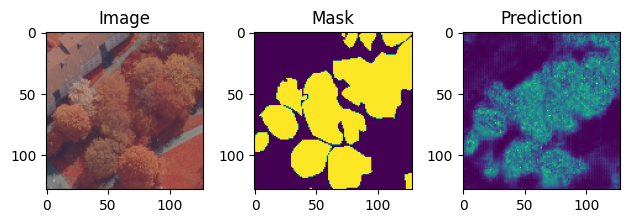

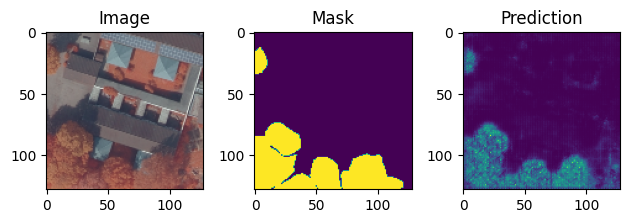

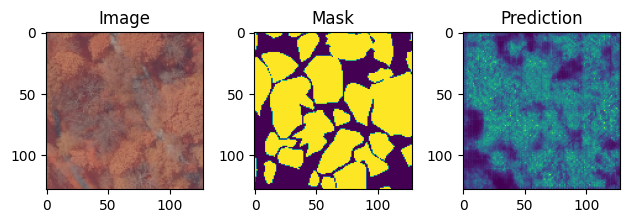

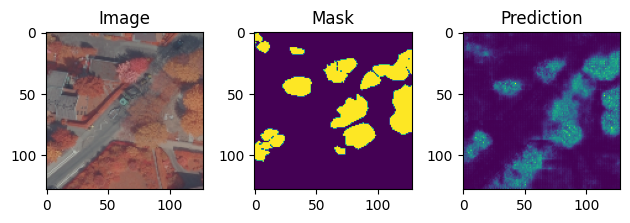

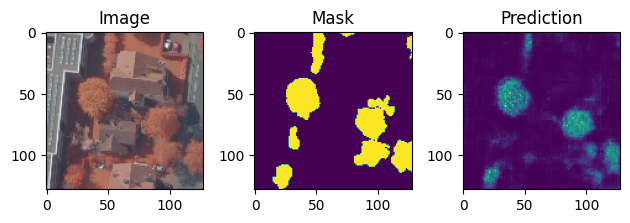

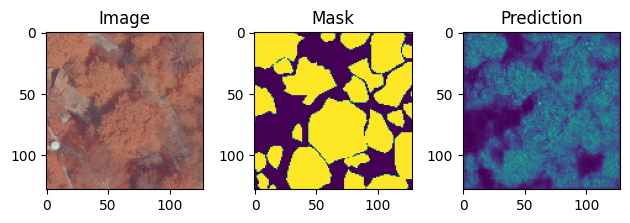

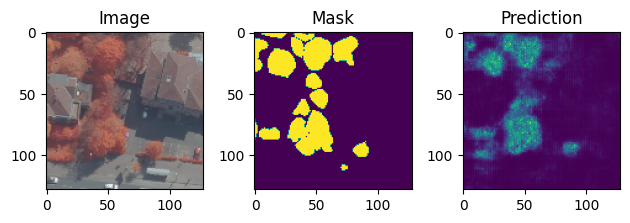

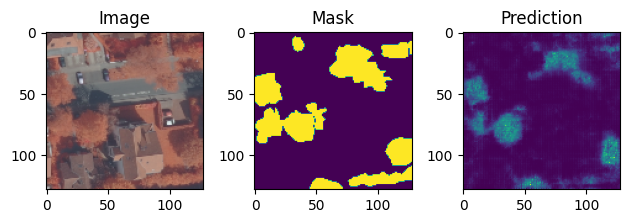

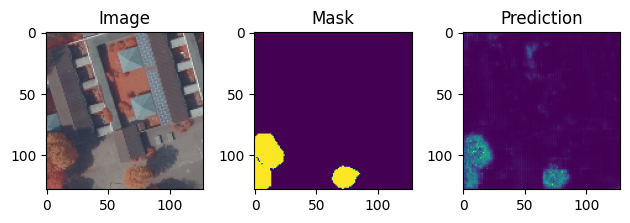

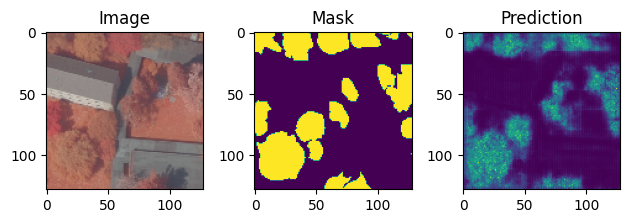

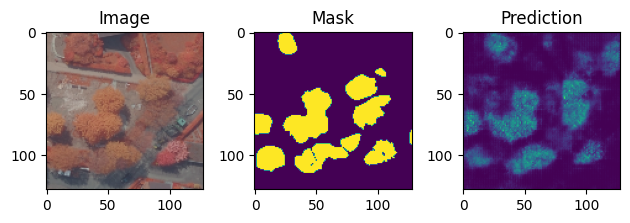

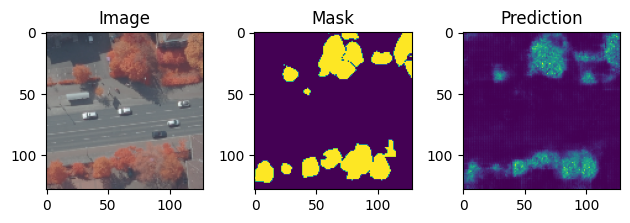

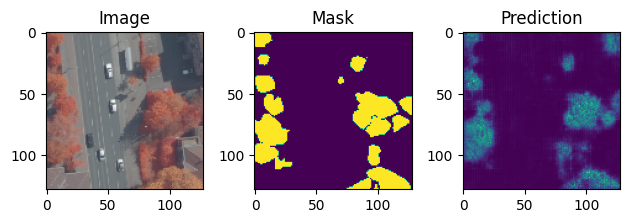

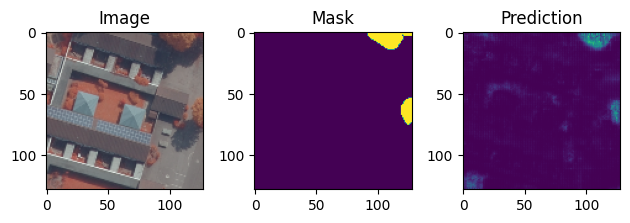

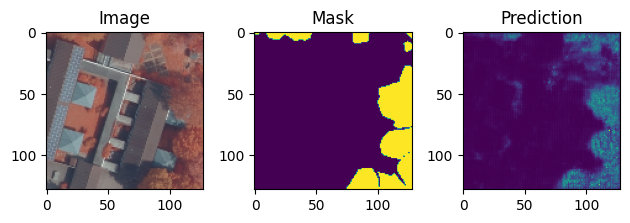

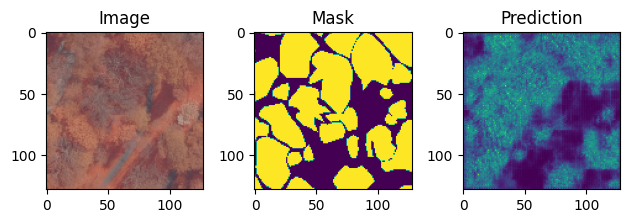

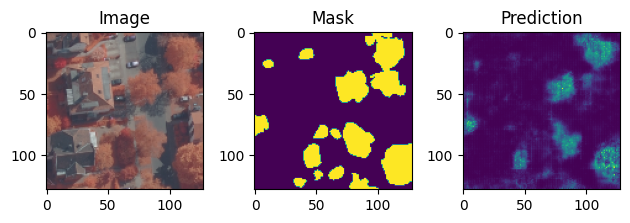

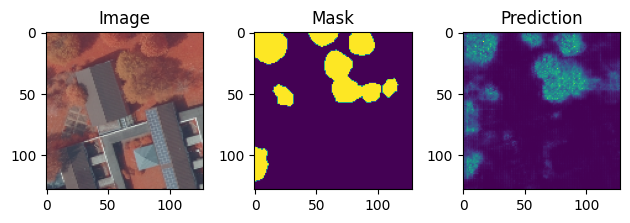

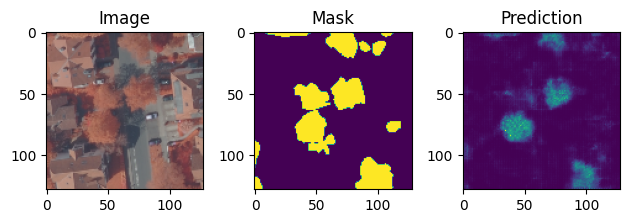

In [31]:
show_predictions(n=20)

In [36]:
import os
if not os.path.exists('models'):
    os.makedirs('models')
model.save('models/u_net.keras')